In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

## *Preparation and reading data*

In [2]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [3]:
df = rawToDf('whatsapp-chat-data.txt', '12hr')

## Pre-Processing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
date_time    13655 non-null datetime64[ns]
user         13655 non-null object
message      13655 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 320.1+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [5]:
df.sample(10)

,date_time,user,message
11505,2020-09-12 21:02:00,"Dheeraj Lalwani (TSEC, CS)",
5648,2020-05-02 17:37:00,+91 99676 84479,Thank you
1289,2020-02-20 23:36:00,"Pratik K (TSEC CS, SE)",oh acha
4293,2020-04-01 01:23:00,"Kartik Soneji (TSEC, CS)",It is like shutting down your PC.
8267,2020-06-29 21:29:00,"Dheeraj Lalwani (TSEC, CS)",this is like spelling of SCHOOL is SCHOOL an...
12190,2020-09-13 20:09:00,"Tanay Kamath (TSEC, CS)",dcoder pe it doesnt
4909,2020-04-18 12:49:00,Tushar Nankani,
10958,2020-08-27 22:19:00,"Darshan Rander (TSEC, IT)",Ab dono se upar aagaye hai😂😂
5802,2020-05-06 23:14:00,"Dheeraj Lalwani (TSEC, CS)",#CodersHelpCoders
682,2020-02-09 15:01:00,"Vivek Iyer (TSEC, Biomed)",Ok


In [6]:
df[df['message'] == ""].shape[0]

538

## Adding extra *helper columns for analysis and visualization*

In [7]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [8]:
df

,date_time,user,message,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sun,Jan,2020,2020-01-26
5,2020-01-26 16:22:00,group_notification,+91 72762 35231 joined using this group's invi...,Sun,Jan,2020,2020-01-26
6,2020-01-26 16:22:00,group_notification,+91 88392 06534 joined using this group's invi...,Sun,Jan,2020,2020-01-26
7,2020-01-26 16:23:00,group_notification,+91 98709 38217 joined using this group's invi...,Sun,Jan,2020,2020-01-26
8,2020-01-26 16:23:00,group_notification,+91 98702 02065 joined using this group's invi...,Sun,Jan,2020,2020-01-26
9,2020-01-26 16:23:00,group_notification,+91 91370 44426 joined using this group's invi...,Sun,Jan,2020,2020-01-26


In [9]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-01-24,1
1,2020-01-26,105
2,2020-01-27,90
3,2020-01-28,126
4,2020-01-29,118
5,2020-01-30,24
6,2020-01-31,13
7,2020-02-01,41
8,2020-02-03,9
9,2020-02-04,20


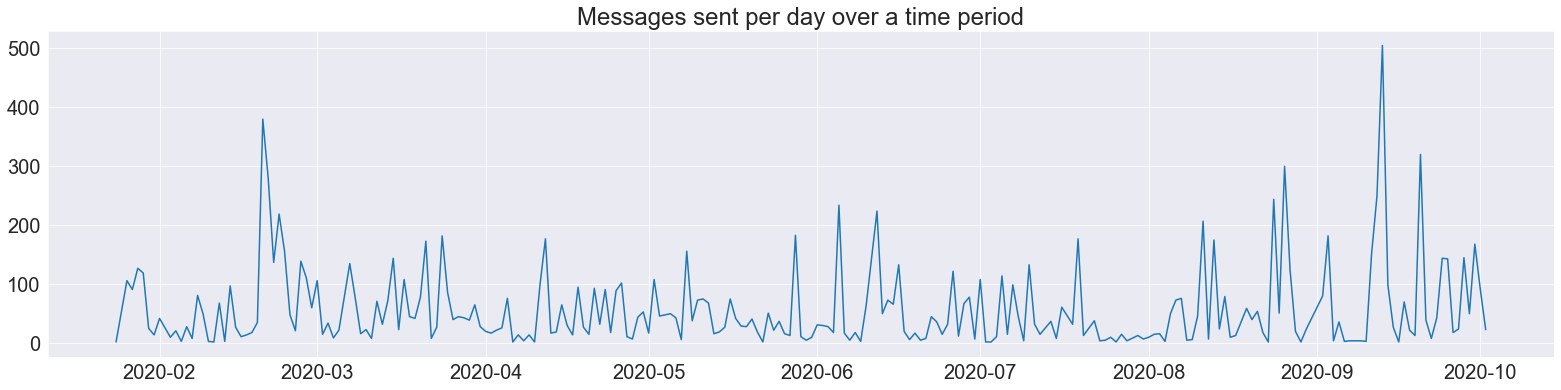

In [10]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2 *Top 10 most active days.*

In [11]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278
5,2020-09-12,249
6,2020-08-24,243
7,2020-06-05,233
8,2020-06-12,223
9,2020-02-23,218


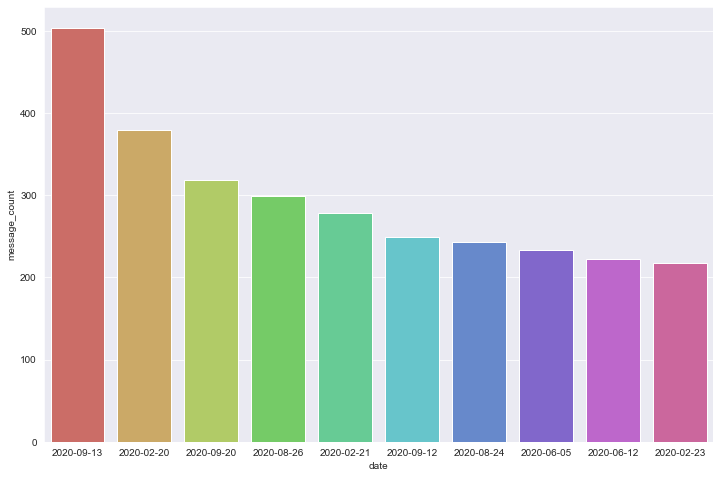

In [12]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

In [13]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


## Now, pre-processing top 10 active users.

In [14]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [15]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

In [16]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

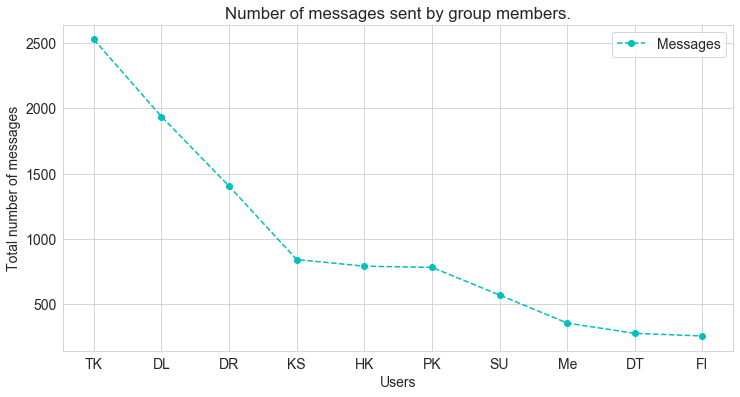

In [17]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

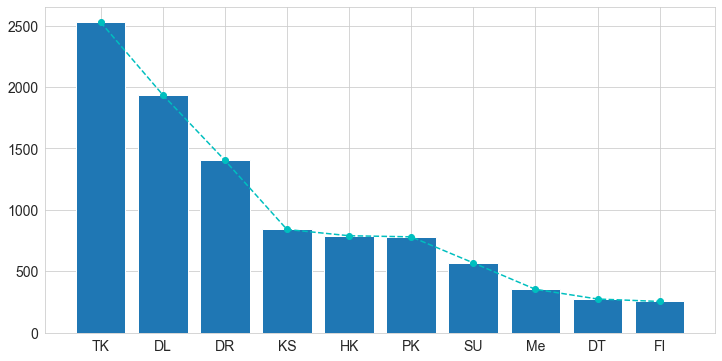

In [18]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

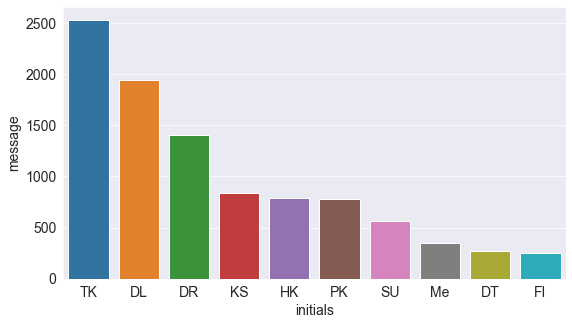

In [19]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(top10df.initials, top10df.message, data=top10df);

In [20]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

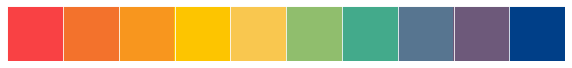

In [21]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [22]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

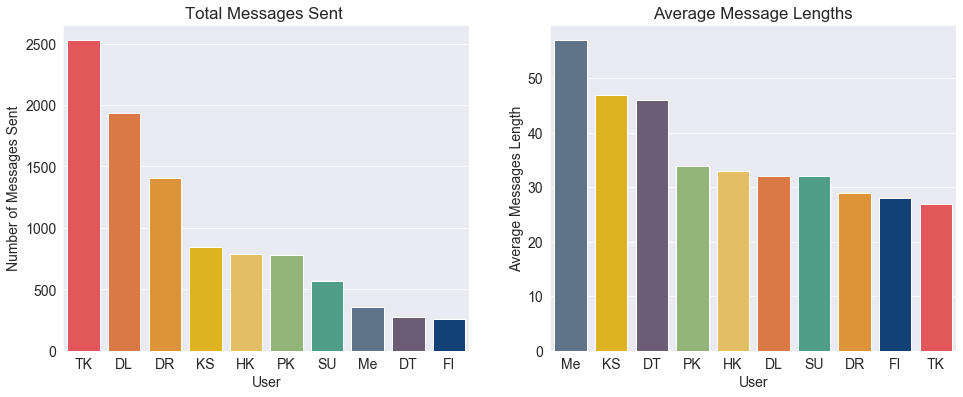

In [23]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(top10df.initials, top10df.message, data=top10df, ax = axes[0], palette=get_colors_of_certain_order(top10df.initials));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.initials, top10df_msg.avg_message_length, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

# 4. Top 10 users most sent media 

In [24]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

### *Visualization using different Seaborn's Color Palettes*
- [Seaborn References](http://seaborn.pydata.org/tutorial/color_palettes.html#using-circular-color-systems)
- [Seaborn's Different Colors](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08)
- [Seaborn's Color Visualization](https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/)

###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

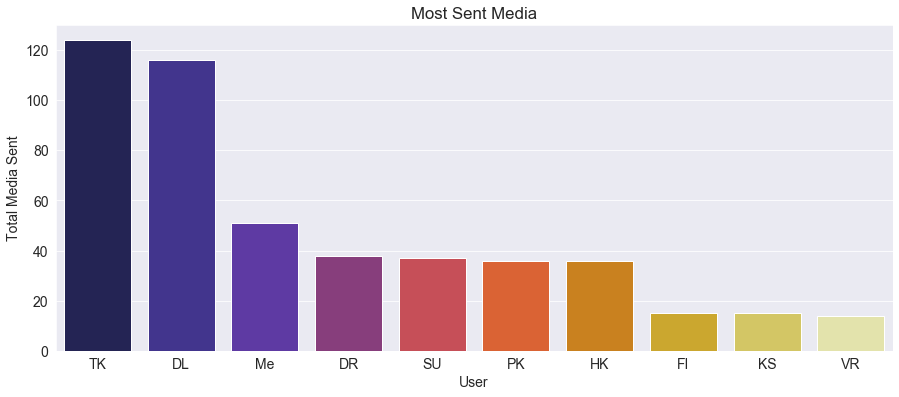

In [25]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(top10media.initials, top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [26]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [27]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,1886,face_with_tears_of_joy
1,👍,364,thumbs_up
2,🏻,247,light_skin_tone
3,🔥,244,fire
4,😅,220,grinning_face_with_sweat
5,💯,180,hundred_points
6,🤣,128,rolling_on_the_floor_laughing
7,🤦‍♂,108,man_facepalming
8,👏,101,clapping_hands
9,🙏,79,folded_hands


### Which Emoji is the most used in the chat?

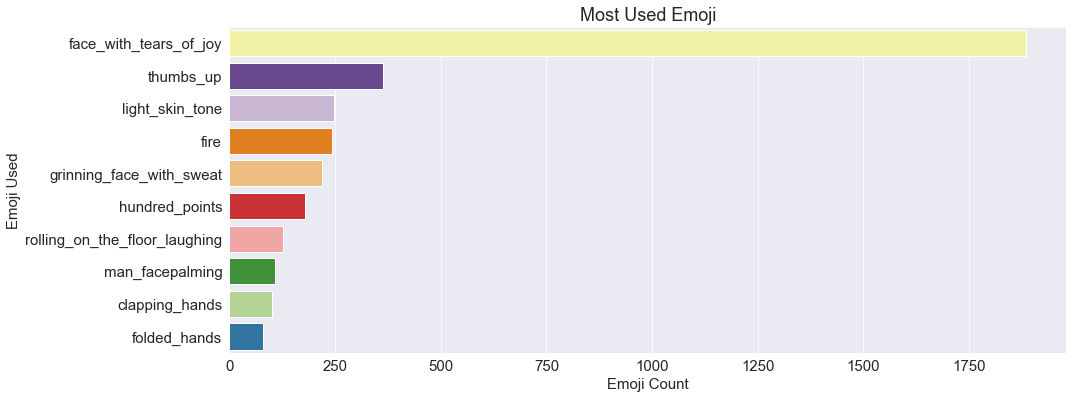

In [28]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(top10emojis.emoji_count, top10emojis.emoji_description, palette = "Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
plt.savefig('top10emoji.svg', format = 'svg')

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [29]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

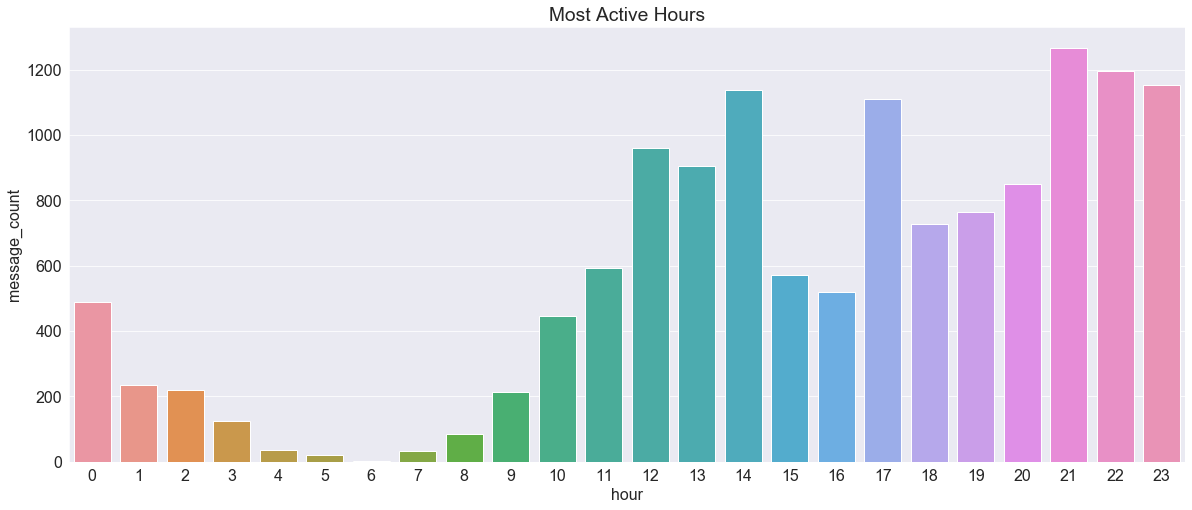

In [30]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [31]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


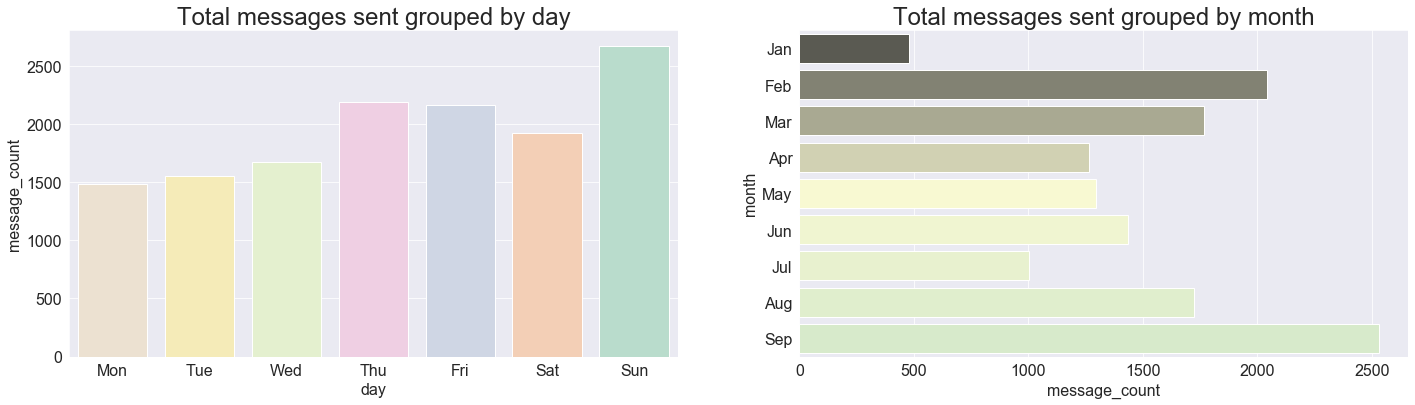

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding! 

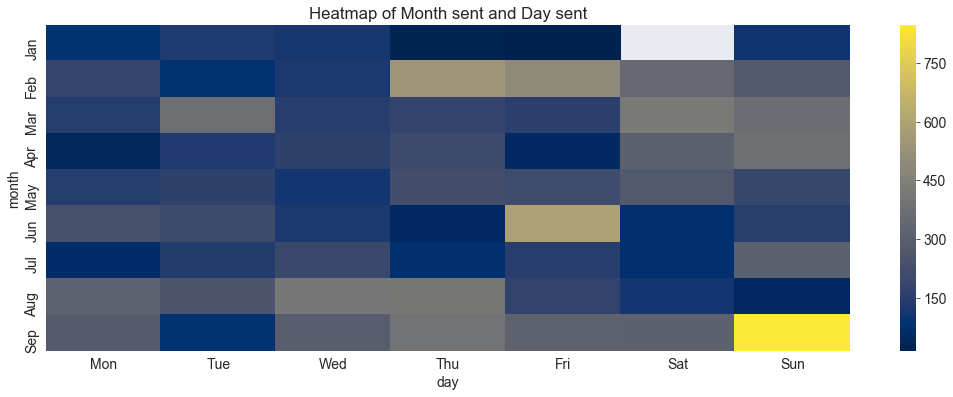

In [33]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [36]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

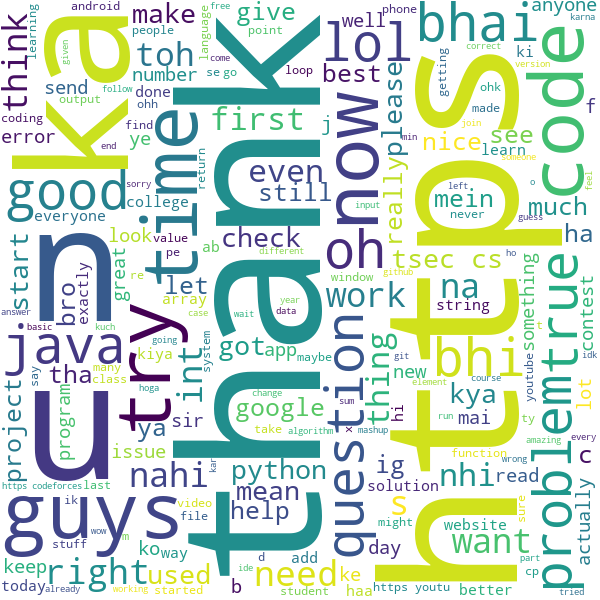

In [37]:
wordcloud.to_image()